# PCA analysis of predictiveness of DEG for gender

In [1]:
#load required packages
import functools
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

## Configuration and functions

### Configuration

In [3]:
feature = 'genes'
config = {
    'deg_file': '../../_m/%s/diffExpr_maleVfemale_full.txt' % feature,
    'res_file': '../../_m/%s/residualized_expression.tsv' % feature,
    'pheno_file': '/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/merged_phenotypes.csv',
    'annot_file': "/ceph/projects/v4_phase3_paper/inputs/counts/text_files_counts/_m/caudate/gene_annotation.tsv",
}

### Cached functions

In [4]:
@functools.lru_cache()
def get_deg():
    ''' Take DE genes obtained from limma-voom pipeline.
    '''
    deg = pd.read_csv(config['deg_file'], sep='\t', index_col=0).sort_values('adj.P.Val')
    return deg[(deg['adj.P.Val'] < 0.05)]


@functools.lru_cache()
def get_residualized():
    '''Load residualization file.
    '''
    return pd.read_csv(config['res_file'], sep='\t', index_col=0).transpose()


@functools.lru_cache()
def get_pheno_data():
    return pd.read_csv(config['pheno_file'], index_col=0)


@functools.lru_cache()
def get_autosomes():
    df = pd.read_csv(config['annot_file'], sep='\t', index_col=0)
    return df[(df["seqnames"].str.contains("chr\d+"))]


@functools.lru_cache()
def get_allosomes():
    df = pd.read_csv(config['annot_file'], sep='\t', index_col=0)
    return df[(df["seqnames"].isin(["chrX", "chrY"]))]


@functools.lru_cache()
def get_deg_res_df(num, fnc, FILTER):
    geneList = list(set(get_deg().index) & set(fnc().index))
    if FILTER:
        newList = list(get_deg().loc[geneList, :].sort_values("P.Value").head(num).index)
    else:
        newList = geneList
    return get_residualized()[newList]

### Simple functions

In [5]:
def get_explained_variance(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit(x)
    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    print("Explained Variance\nPC1:\t%0.5f\nPC2:\t%0.5f" % (pc1, pc2))
    
    
def cal_pca(df):
    x = StandardScaler().fit_transform(df)
    pca = PCA(n_components=2).fit_transform(x)
    return pd.DataFrame(data=pca, columns=['PC1', 'PC2'], index=df.index)


def get_pca_df(num, fnc, FILTER):
    '''
    new_pheno: this is the correct size of samples using the the first two columns of residualized expression
      - the residualized expression data frame, has the correct samples
      - output new_pheno shape row numbers should be the same as res_df row numbers
    '''
    expr_res = get_deg_res_df(num, fnc, FILTER)
    pheno_df = get_pheno_data()
    # Generate pheno data frame with correct samples
    new_pheno = pheno_df.merge(expr_res.iloc[:, 0:1], right_index=True, left_index=True)\
                        .drop(expr_res.iloc[:, 0:1].columns, axis=1)
    principalDf = cal_pca(expr_res)
    get_explained_variance(expr_res)
    return pd.concat([principalDf, new_pheno], axis = 1)


def calculate_corr(xx, yy):
    '''This calculates R^2 correlation via linear regression:
         - used to calculate relationship between 2 arrays 
         - the arrays are principal components 1 or 2 (PC1, PC2) AND ancestry
         - calculated on a scale of 0 to 1 (with 0 being no correlation)
        Inputs: 
          x: array of variable of interest (continous or binary)
          y: array of PC
        Outputs: 
          1. r2
          2. p-value, two-sided test 
            - whose null hypothesis is that two sets of data are uncorrelated
          3. slope (beta): directory of correlations
    '''
    slope, intercept, r_value, p_value, std_err = linregress(xx, yy)
    return slope, r_value, p_value

    
def corr_annotation(dft):
    xx = dft.Sex.astype('category').cat.codes
    yy = dft.PC1
    zz = dft.PC2
    slope1, r_value1, p_value1 = calculate_corr(xx, yy)
    slope2, r_value2, p_value2 = calculate_corr(xx, zz)
    label = 'PC1 R2: %.2f\nP-value: %.2e' % (r_value1**2, p_value1)
    print('PC2 R2: %.4f Pval: %.3e' % (r_value2**2, p_value2))
    return label


def get_corr(dft):
    xx = dft.Sex.astype('category').cat.codes
    yy = dft.PC1
    slope1, r_value1, p_value1 = calculate_corr(xx, yy)
    return r_value1**2, p_value1

### Plotting functions

In [6]:
def plot_corr_impl(num, fnc, FILTER):
    pca_df = get_pca_df(num, fnc, FILTER)
    #pca_df['Sex'] = pca_df.Sex.astype('category').cat
    title = '\n'.join([corr_annotation(pca_df)])
    pp = ggplot(pca_df, aes(x='PC1', y='PC2', fill='Sex'))\
    + geom_point(alpha=0.75, size=4)\
    + theme_matplotlib()\
    + theme(axis_text_x=element_blank(), 
            axis_text_y=element_text(size=18), 
            axis_title=element_text(size=21), 
            plot_title=element_text(size=22),
            legend_text=element_text(size=16), 
            legend_title=element_blank(), 
            legend_position="bottom")
    pp += ggtitle(title)
    return pp


def plot_corr(num, fnc, FILTER=False):
    return plot_corr_impl(num, fnc, FILTER)


def save_plot(p, fn, width=7, height=7):
    '''Save plot as svg, png, and pdf with specific label and dimension.'''
    for ext in ['.svg', '.png', '.pdf']:
        p.save(fn+ext, width=width, height=height)


## PCA analysis

### Allosomes

Explained Variance
PC1:	0.39317
PC2:	0.15679
PC2 R2: 0.0621 Pval: 1.740e-06


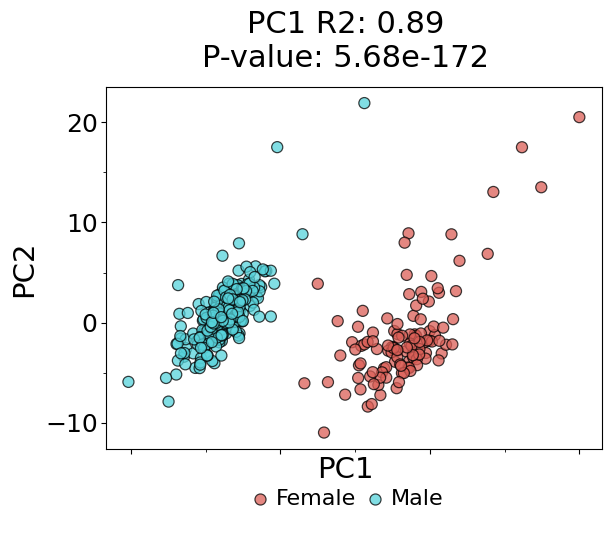

<ggplot: (8758128805581)>

In [7]:
pp = plot_corr(0, get_allosomes, False)
save_plot(pp, 'deg_pca_all_allosomes')
pp

### Autosomes

Explained Variance
PC1:	0.36649
PC2:	0.05833
PC2 R2: 0.0007 Pval: 6.151e-01


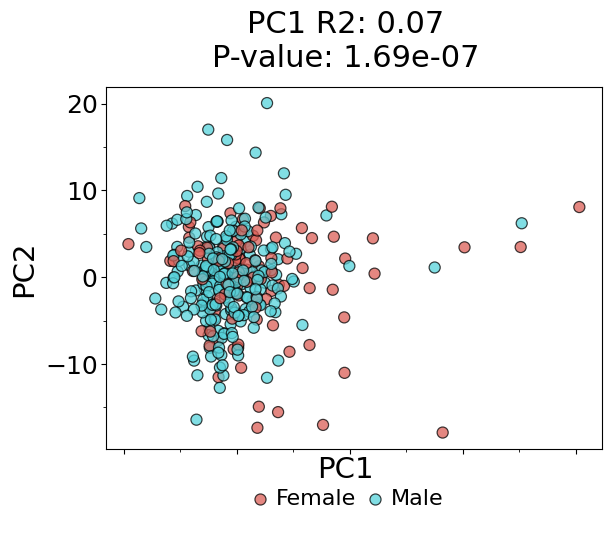

<ggplot: (8758128923049)>

In [8]:
qq = plot_corr(0, get_autosomes, False)
save_plot(qq, 'deg_pca_all_autosomes')
qq

In [9]:
pheno_df = get_pheno_data()
geneList = list(set(get_deg().index) & set(get_autosomes().index))
pvals = []; rsq = []; nums = []
for num in range(2,len(geneList)+1):
    expr_res = get_deg_res_df(num, get_autosomes, True)
    # Generate pheno data frame with correct samples
    new_pheno = pheno_df.merge(expr_res.iloc[:, 0:1], right_index=True, left_index=True)\
                        .drop(expr_res.iloc[:, 0:1].columns, axis=1)
    principalDf = cal_pca(expr_res)
    dft = pd.concat([principalDf, new_pheno], axis = 1)
    r2,pval = get_corr(dft)
    nums.append(num); pvals.append(pval); rsq.append(r2)
rsq_df = pd.DataFrame({"DEGs":nums, "PValue":pvals, "Rsq": rsq})
rsq_df.head(2)

,DEGs,PValue,Rsq
0,2,7.123180e-22,0.228289
1,3,1.607993e-27,0.282083


In [10]:
rsq_df.sort_values("Rsq", ascending=False).head(2)

,DEGs,PValue,Rsq
24,26,5.656795e-49,0.454923
29,31,1.144703e-48,0.452774


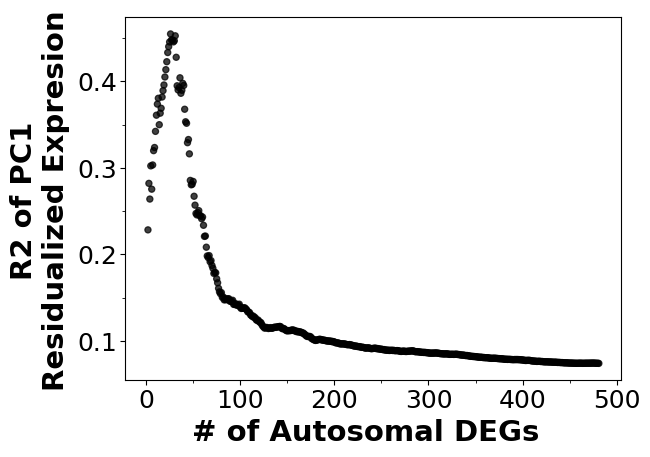

<ggplot: (8758131342023)>

In [11]:
gg = ggplot(rsq_df, aes(x='DEGs', y='Rsq'))\
    + geom_point(alpha=0.75, size=2)\
    + theme_matplotlib()\
    + labs(x="# of Autosomal DEGs", y="R2 of PC1\nResidualized Expresion")\
    + theme(axis_text=element_text(size=18), 
            axis_title=element_text(size=21, face="bold"))
gg

In [ ]:
save_plot(gg, 'autosomes_rsq_curve')

Explained Variance
PC1:	0.39487
PC2:	0.15652
PC2 R2: 0.1111 Pval: 9.188e-11


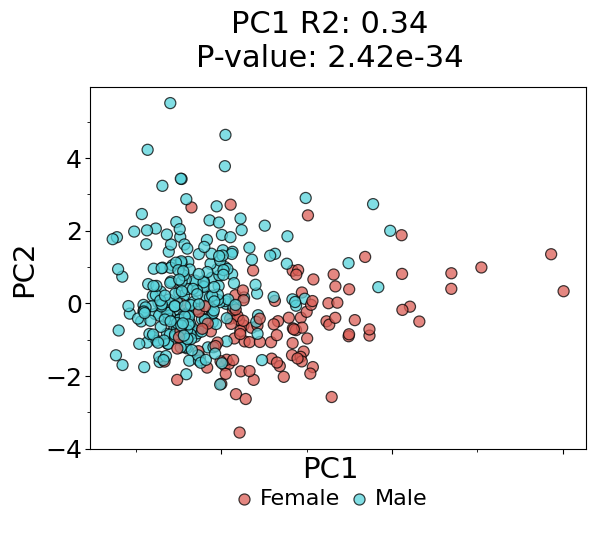

<ggplot: (8758128941725)>

In [12]:
qq1 = plot_corr(10, get_autosomes, True)
save_plot(qq1, 'deg_pca_top10_autosomes')
qq1

Explained Variance
PC1:	0.21070
PC2:	0.12377
PC2 R2: 0.0142 Pval: 2.419e-02


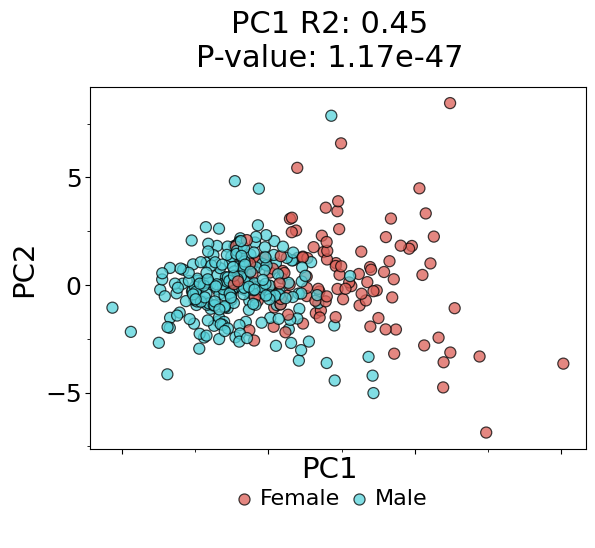

<ggplot: (8758129323825)>

In [14]:
qq2 = plot_corr(25, get_autosomes, True)
save_plot(qq2, 'deg_pca_top25_autosomes')
qq2